### Plot Figure 1 (Overview map)

This notebook plots Figure 1 of the Paper. Note that it uses netcdf files instead of Climada exposures (available upon request from raphael.portmann@alumni.ethz.ch)

In [1]:
import sys

from pathlib import Path
#add path to path of current skript, where also utility.py lies
sys.path.append(Path.cwd().absolute())
#own functions
from utility import plot_CH_map, data_dir, read_at_centroid_data, compute_verification_stats,plot_measures_per_event, en_names, plot_CH_map

#others
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import pickle
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Transformer
import rioxarray as rxr

In [2]:
croptypes=['Weizen_Mais_Raps_Gerste','Reben']

# set directories
datapath = f'{data_dir}/damage_exposure_netcdf/'
figdir = 'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/fig/'
datadir = 'C:/Users/F80840370/projects/scClim/climada/data/'

#read damage/exposure data
damages_exposure_data={}
for croptype in croptypes:
    filename=f'{datapath}/damage_claims_SHV_{croptype}_gridded_1km.nc'
    damages_exposure_data[croptype]=xr.open_dataset(filename)


If the relief .tif file is available we can load that as well

In [32]:
#da_relief = rxr.open_rasterio(data_dir+'/relief_georef_clipped_swiss.tif')

c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [21]:
# #prepare relief data
# relief_crs = 'EPSG:2056' #da_relief.rio.crs

# # Compute the lon/lat coordinates with rasterio.warp.transform
# ny, nx = len(da_relief['y']), len(da_relief['x'])
# x, y = np.meshgrid(da_relief['x'], da_relief['y'])

# # Rasterio works with 1D arrays
# outProj = 'EPSG:4326' # WGS84, see https://epsg.io/4326
# transformer = Transformer.from_crs(relief_crs, outProj)
# lat, lon = transformer.transform(x.flatten(), y.flatten())
# lon = np.asarray(lon).reshape((ny, nx))-0.01
# lat = np.asarray(lat).reshape((ny, nx))
# da_relief.coords['lon'] = (('y', 'x'), lon)
# da_relief.coords['lat'] = (('y', 'x'), lat)

# # get band
# da_relief = da_relief.isel(band=0, drop=True)
# da_relief = da_relief.where(da_relief > 1, drop=True)

c:\Users\F80840370\Anaconda3\envs\climada_env_3.9\lib\site-packages\rioxarray\_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


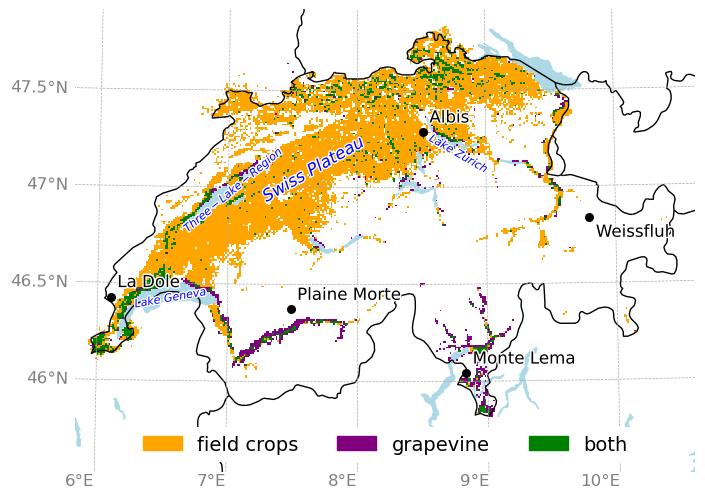

In [4]:
#cmap
colrs=['orange','purple','green']
names=['field crops','grapevine','both']
cMap = matplotlib.colors.ListedColormap(colrs)
# create a patch (proxy artist) for every color to use in legend
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=colrs[j], label=names[j]) for j in range(len(names))]

fontsize=12
#matplotlib.rcParams.update({'font.size': fontsize,'axes.labelsize': fontsize,'axes.edgecolor': 'none'})

lon=damages_exposure_data['Reben'].lon.values[0,:,:]
lat=damages_exposure_data['Reben'].lat.values[0,:,:]

fig, axes,exts=plot_CH_map(nrows=1,ncols=1,figsize=(8,10),stamen_map=False, proj=ccrs.PlateCarree(), pads=[0.1,0.1,0.3,0.1], edgecolor=None)

ax=axes[0]
gl=ax.gridlines(draw_labels=["bottom","left"], x_inline=False, y_inline=False,linestyle='--',
                linewidth=0.5,color='darkgrey',xlabel_style={'color':'grey','size':fontsize,'rotation':'horizontal'},
                ylabel_style={'color':'grey','size':fontsize})
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')


#prepare binary data
field_crops=np.where(damages_exposure_data['Weizen_Mais_Raps_Gerste']['n_fields_exp'].values>0,1,0)
grapevine=np.where(damages_exposure_data['Reben']['n_fields_exp'].values>0,2,0)
data=field_crops+grapevine
    
#prepare data for plotting
data = np.ma.masked_where(data == 0, data)

hs=ax.pcolormesh(lon,lat,data,
                         transform=ccrs.PlateCarree(),
                         cmap=cMap) #label='false alarms')

ax.legend(handles=patches,ncol=4,loc='center',bbox_to_anchor=(0.5, 0.06),edgecolor='none',facecolor='w',framealpha=1,fontsize=14)    
            #l=ax.get_legend()
            #l.set_zorder(10)

#name locations

#Define location of Swiss radars and save to pd.Dataframe
albis =         (47.284380558879924,    8.512012256288788)
monte_lema =    (46.0407749638419,      8.833287438635887)
plaine_morte =  (46.37066695182743,     7.48649280864315)
la_dole =       (46.425685686212404,    6.100087861038654)
weissfluh =     (46.83497304383815,     9.79458732101177)


radar_df = pd.DataFrame(index=['Albis','Monte Lema','Plaine Morte','La Dole','Weissfluh'],
                        columns=['lat','lon'],data=[albis,monte_lema,plaine_morte,la_dole,weissfluh])
transform = ccrs.PlateCarree()._as_mpl_transform(ax)
for i, label in enumerate(radar_df.index):
    y_shift = -0.15 if label=='Weissfluh' else 0
    ax.annotate(label, xy=(radar_df.lon[i], radar_df.lat[i]),
                xytext=(radar_df.lon[i]+0.05, radar_df.lat[i]+0.05+y_shift),
                xycoords=transform,fontsize=fontsize,zorder=4,
                path_effects=[matplotlib.patheffects.withStroke(linewidth=2, foreground='white')])

ax.scatter(radar_df.lon,radar_df.lat,marker='o',color='black',s=30,transform=ccrs.PlateCarree(),zorder=4)

#Define location of Swiss lakes and regions and save to pd.Dataframe
lake_zurich =         (47.271108,    8.611633)
lake_geneva =    (46.445164,      6.484824)
three_lakes =  (46.959397,   7.052996)
swiss_plateau = (47.125768, 7.3626658)

rotations=[-30,10,40,30]
yshifts=[-0.2,-0.07,-0.19,-0.2]
xshifts=[0.18,0.08,-0.01,0.3]
fontsizes=[8,8,8,12]
lakes_df = pd.DataFrame(index=['$\it{Lake~Zurich}$','$\it{Lake~Geneva}$','$\it{Three-Lake-Region}$','$\it{Swiss~Plateau}$'],
                        columns=['lat','lon'],data=[lake_zurich,lake_geneva,three_lakes,swiss_plateau])

for i, label in enumerate(lakes_df.index):
    
    ax.annotate(label, xy=(lakes_df.lon[i], lakes_df.lat[i]),
                xytext=(lakes_df.lon[i]+xshifts[i], lakes_df.lat[i]+yshifts[i]), color='blue', rotation=rotations[i],
                xycoords=transform,fontsize=fontsizes[i],zorder=4,ha='center', 
                path_effects=[matplotlib.patheffects.withStroke(linewidth=2, foreground='w')])
    



#add relief iif available
#da_relief.plot(ax=ax, x='lon', y='lat', cmap="Greys_r",norm=colors.Normalize(vmin=110, vmax=255), 
#               add_colorbar=False, transform=ccrs.PlateCarree(),zorder=0.5)


In [ ]:
fig.savefig(f'{figdir}/Figure_1.png',dpi=100,bbox_inches='tight')
fig.savefig(f'{figdir}/Figure_1.pdf',dpi=100,bbox_inches='tight')